In [43]:
import heapq
import numpy as np
import matplotlib.pyplot as plt

In [44]:
# Paramètres globaux
N_SERVEURS = 12
QUEUE_SIZE = 100
C_VALUES = [1, 2, 3, 6]
LAMBDA_VALUES = np.linspace(0.1, 2, 10)  # Valeurs de lambda à tester
LAMBDA_VALUES = np.linspace(0.1, 10, 15)  # Augmenter la plage des valeurs de λ

SIMULATION_TIME = 10000  # Temps total de simulation
CONFIDENCE_LEVEL = 1.96  # Intervalle de confiance à 95%

In [45]:
# Génération de variables exponentielles
def exp_rnd(lmbda):
    return -np.log(np.random.uniform()) / lmbda

In [46]:
class Requete:
    def __init__(self, time, category):
        self.time = time  # Temps d'arrivée
        self.category = category  # Catégorie de la requête

class Serveur:
    def __init__(self):
        self.busy = False
        self.end_time = 0

class Routeur:
    def __init__(self, C):
        self.queue = []  # File d'attente FIFO
        self.capacity = QUEUE_SIZE
        self.C = C  # Nombre de groupes
        self.servers = {i: [Serveur() for _ in range(N_SERVEURS // C)] for i in range(C)}
        self.loss_count = 0  # Nombre de requêtes perdues

    def receive_request(self, event_queue, current_time, request):
        if len(self.queue) < self.capacity:
            self.queue.append(request)
            heapq.heappush(event_queue, (current_time + (self.C - 1) / self.C, 'route_request'))
        else:
            self.loss_count += 1  # Requête perdue

    def route_request(self, event_queue, current_time):
        if self.queue:
            request = self.queue.pop(0)
            group = request.category % self.C
            servers = self.servers[group]
            
            for server in servers:
                if not server.busy:
                    server.busy = True
                    service_time = exp_rnd({1: 4/20, 2: 7/20, 3: 10/20, 6: 14/20}[self.C])
                    server.end_time = current_time + service_time
                    heapq.heappush(event_queue, (server.end_time, 'end_service', server, group))
                    return
            
            self.queue.insert(0, request)  # Remet la requête si aucun serveur libre

    def end_service(self, event_queue, current_time, server, group):
        server.busy = False
        if self.queue:
            self.route_request(event_queue, current_time)

In [47]:
def confidence_interval(data, confidence=0.95):
    """Calcule l'intervalle de confiance à 95%."""
    if len(data) == 0:
        return 0, 0
    mean = np.mean(data)
    std_dev = np.std(data, ddof=1)  # Degré de liberté = 1 pour échantillon
    margin = CONFIDENCE_LEVEL * (std_dev / np.sqrt(len(data)))  # Intervalle de confiance
    return mean, margin


In [48]:
def simulate(C, lmbda):
    event_queue = []  # File d'événements (min-heap)
    routeur = Routeur(C)
    current_time = 0
    request_count = 0
    total_response_time = []
    
    # Génération de la première arrivée
    heapq.heappush(event_queue, (exp_rnd(lmbda), 'arrival'))
    
    while current_time < SIMULATION_TIME and event_queue:
        current_time, event, *args = heapq.heappop(event_queue)
        
        if event == 'arrival':
            category = np.random.randint(0, C)
            request = Requete(current_time, category)
            routeur.receive_request(event_queue, current_time, request)
            heapq.heappush(event_queue, (current_time + exp_rnd(lmbda), 'arrival'))
            request_count += 1
        
        elif event == 'route_request':
            routeur.route_request(event_queue, current_time)
        
        elif event == 'end_service':
            server, group = args
            routeur.end_service(event_queue, current_time, server, group)
            total_response_time.append(current_time)
    
    avg_response_time = np.mean(total_response_time) if total_response_time else float('inf')
    loss_rate = routeur.loss_count / request_count if request_count else 0
    return avg_response_time, loss_rate


In [49]:
N_RUNS = 30  # Nombre de répétitions

response_times = {C: [] for C in C_VALUES}
response_intervals = {C: [] for C in C_VALUES}  # Intervalle de confiance
loss_rates = {C: [] for C in C_VALUES}
loss_intervals = {C: [] for C in C_VALUES}  # Intervalle de confiance pour le taux de perte


for C in C_VALUES:
    for lmbda in LAMBDA_VALUES:
        times = []
        losses = []
        for _ in range(N_RUNS):  
            avg_time, loss_rate = simulate(C, lmbda)
            times.append(avg_time)
            losses.append(loss_rate)

        mean_time, margin_time = confidence_interval(times)
        mean_loss, margin_loss = confidence_interval(losses)


        response_times[C].append(mean_time)
        response_intervals[C].append(margin_time)
        loss_rates[C].append(mean_loss)
        loss_intervals[C].append(margin_loss)



In [50]:
optimal_C = {}

for i, lmbda in enumerate(LAMBDA_VALUES):
    best_C = None
    best_time = float('inf')

    for C in C_VALUES:
        if loss_rates[C][i] <= 0.05:  # Vérifier que la perte est < 5%
            if response_times[C][i] < best_time:
                best_time = response_times[C][i]
                best_C = C

    optimal_C[lmbda] = best_C

# Affichage des résultats
print("Valeurs optimales de C en fonction de λ :")
for lmbda, C_opt in optimal_C.items():
    print(f"λ = {lmbda:.2f} → C optimal = {C_opt}")


Valeurs optimales de C en fonction de λ :
λ = 0.10 → C optimal = 2
λ = 0.81 → C optimal = 3
λ = 1.51 → C optimal = 6
λ = 2.22 → C optimal = 3
λ = 2.93 → C optimal = 3
λ = 3.64 → C optimal = 3
λ = 4.34 → C optimal = None
λ = 5.05 → C optimal = None
λ = 5.76 → C optimal = None
λ = 6.46 → C optimal = None
λ = 7.17 → C optimal = None
λ = 7.88 → C optimal = None
λ = 8.59 → C optimal = None
λ = 9.29 → C optimal = None
λ = 10.00 → C optimal = None


In [57]:
# Trouver l'index de la valeur de λ la plus proche de 1
lambda_1_index = np.argmin(np.abs(LAMBDA_VALUES - 1))
lambda_1_real = LAMBDA_VALUES[lambda_1_index]  # Valeur réelle de λ la plus proche

# Récupérer le C optimal pour cette valeur
chosen_C = optimal_C[lambda_1_real]

# Affichage des performances pour λ ≈ 1
print(f"\n📌 Analyse pour λ ≈ {lambda_1_real:.2f} :")
for C in C_VALUES:
    print(f"C={C} → Temps moyen : {response_times[C][lambda_1_index]:.2f}, "
          f"Taux de perte : {loss_rates[C][lambda_1_index]:.4f}")

print(f"\n✅ Pour λ ≈ {lambda_1_real:.2f}, le C optimal sélectionné est **C = {chosen_C}**")



📌 Analyse pour λ ≈ 0.81 :
C=1 → Temps moyen : 5006.84, Taux de perte : 0.0000
C=2 → Temps moyen : 4998.49, Taux de perte : 0.0000
C=3 → Temps moyen : 4994.22, Taux de perte : 0.0000
C=6 → Temps moyen : 5002.25, Taux de perte : 0.0000

✅ Pour λ ≈ 0.81, le C optimal sélectionné est **C = 3**


In [55]:
lambda_limits = {}

for C in C_VALUES:
    limit_lambda = None
    for i, lmbda in enumerate(LAMBDA_VALUES):
        if loss_rates[C][i] > 0.05:  # Dès que le taux de perte dépasse 5%
            limit_lambda = lmbda
            break  # On prend la première valeur dépassant 5%
    lambda_limits[C] = limit_lambda

# Affichage des résultats
print("\nValeurs limites de λ où le taux de perte dépasse 5% :")
for C, lmbda in lambda_limits.items():
    print(f"C = {C} → λ limite = {lmbda:.2f}" if lmbda else f"C = {C} → Aucun dépassement détecté")



Valeurs limites de λ où le taux de perte dépasse 5% :
C = 1 → λ limite = 2.93
C = 2 → λ limite = 3.64
C = 3 → λ limite = 4.34
C = 6 → λ limite = 3.64


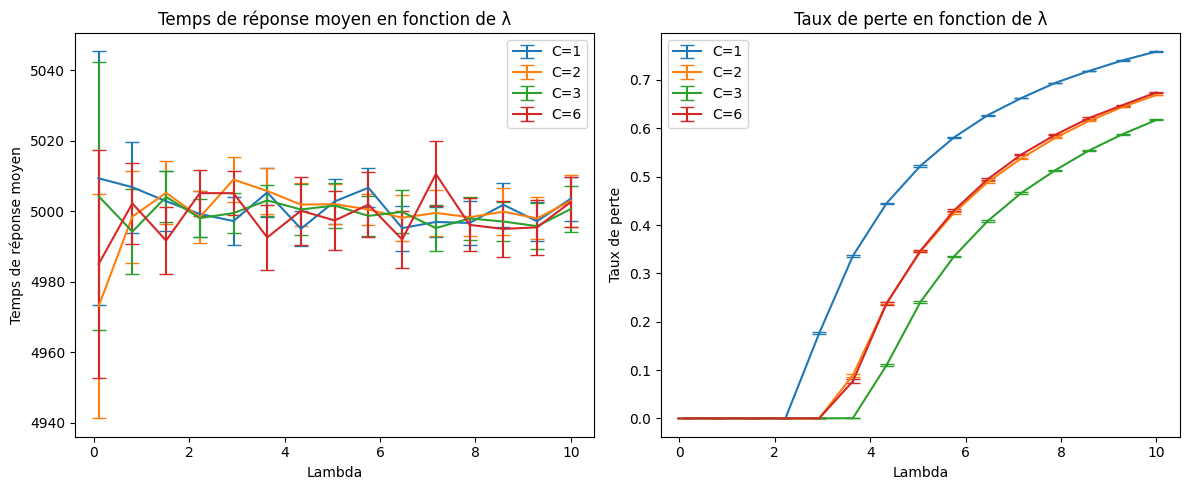

In [52]:
# Tracé des courbes
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for C in C_VALUES:
    plt.errorbar(LAMBDA_VALUES, response_times[C], yerr=response_intervals[C], label=f'C={C}', capsize=5)
plt.xlabel('Lambda')
plt.ylabel('Temps de réponse moyen')
plt.title('Temps de réponse moyen en fonction de λ')
plt.legend()

plt.subplot(1, 2, 2)
for C in C_VALUES:
    plt.errorbar(LAMBDA_VALUES, loss_rates[C], yerr=loss_intervals[C], label=f'C={C}', capsize=5)
plt.xlabel('Lambda')
plt.ylabel('Taux de perte')
plt.title('Taux de perte en fonction de λ')
plt.legend()

plt.tight_layout()
plt.show()